In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
import time
import tqdm
import torch
import IPython
import torchvision

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO

In [2]:
dataPath = os.path.join('C:/', 'Users','andrew','Documents','machineLearning','datasets')

In [3]:
useNet = 'alexnet'
if useNet=='resnet':
    resnet = torchvision.models.resnet18(weights='DEFAULT')
    preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
elif useNet=='alexnet':
    alexnet = torchvision.models.alexnet(weights='DEFAULT')
    preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
elif useNet=='squeezenet':
    squeezenet = torchvision.models.squeezenet1_0(weights='DEFAULT')
    preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
elif useNet=='efficientnet':
    efficientnet = torchvision.models.efficientnet_b0(weights='DEFAULT')
    preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
else:
    raise ValueError("useNet string not recognized")
        
dataSet = 'cifar100'
if dataSet=='cifar10':
    trainset = torchvision.datasets.CIFAR10(root=dataPath, train=True, download=True, transform=preprocess)
    testset = torchvision.datasets.CIFAR10(root=dataPath, train=False, download=True, transform=preprocess)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)
    numClasses = 10
    
elif dataSet=='cifar100':
    trainset = torchvision.datasets.CIFAR100(root=dataPath, train=True, download=True, transform=preprocess)
    testset = torchvision.datasets.CIFAR100(root=dataPath, train=False, download=True, transform=preprocess)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)
    numClasses = 100
    
elif dataSet=='imagenet':
    trainset = torchvision.datasets.ImageNet(root=imagenetPath, train=True, download=True, transform=preprocess)
    testset = torchvision.datasets.ImageNet(root=imagenetPath, train=False, download=True, transform=preprocess)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
    numClasses = 1000
    
else:
    raise ValueError("Dataset not recognized")
    

Files already downloaded and verified
Files already downloaded and verified


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [5]:
if useNet=='resnet':
    # Update classification layer for cifar10
    for param in resnet.parameters():
        param.requires_grad = False

    # ResNet final fully connected layer
    numFeatures = resnet.fc.in_features

    resnet.fc = nn.Linear(numFeatures, numClasses)
    resnet.to(DEVICE)
    optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    
elif useNet=='alexnet':
    for param in alexnet.parameters():
        param.requires_grad = False
    numFeatures = alexnet.classifier[6].in_features
    
    alexnet.classifier[6] = nn.Linear(numFeatures, numClasses)
    alexnet.to(DEVICE)
    optimizer = torch.optim.Adam(alexnet.classifier[6].parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    
elif useNet=='squeezenet':
    for param in squeezenet.parameters():
        param.requires_grad = False
        
    numFeatures = squeezenet.classifier[1].in_channels
    kernel_size = squeezenet.classifier[1].kernel_size
    stride = squeezenet.classifier[1].stride
    
    squeezenet.classifier[1] = nn.Conv2d(numFeatures, numClasses, kernel_size=kernel_size, stride=stride)
    squeezenet.to(DEVICE)
    optimizer = torch.optim.Adam(squeezenet.classifier[1].parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss()

elif useNet=='efficientnet':
    for param in efficientnet.parameters():
        param.requires_grad = False
        
    numFeatures = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(numFeatures, numClasses)
    efficientnet.to(DEVICE)
    optimizer = torch.optim.Adam(efficientnet.classifier[1].parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    
else:
    raise ValueError("Didn't recognize useNet name (should be one of the above listed in if/elifs)")

In [7]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

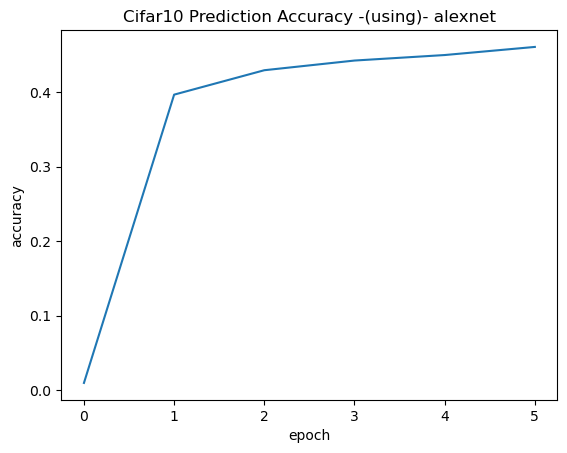

In [6]:
# @title Finetune readout of ResNet
linreadout_accs = []
numEpochs = 5

for epoch in range(numEpochs):
    print(f"Working through epoch: {epoch+1}/{numEpochs}")

    # Eval loop
    with torch.no_grad():
        loss_sum = 0
        total_correct = 0
        total = len(testset)
        for batch in testloader:
            images, labels = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            if useNet=='resnet':
                output = resnet(images)
            elif useNet=='alexnet':
                output = alexnet(images)
            elif useNet=='squeezenet':
                output = squeezenet(images)
            elif useNet=='efficientnet':
                output = efficientnet(images)
            else:
                raise ValueError("Didn't recognize useNet string")
                
            loss = loss_fn(output, labels)
            loss_sum += loss.item()

            predictions = torch.argmax(output, dim=1)

            num_correct = torch.sum(predictions == labels)
            total_correct += num_correct

        # Plot accuracy
        linreadout_accs.append(total_correct.cpu() / total)
        plt.plot(linreadout_accs)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title(dataSet + ' Prediction Accuracy'+' -(using)- '+useNet)
        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf())
    plt.close()
        
    # Train loop
    for batch in trainloader:
        images, labels = batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        if useNet=='resnet':
            output = resnet(images)
        elif useNet=='alexnet':
            output = alexnet(images)
        elif useNet=='squeezenet':
            output = squeezenet(images)
        elif useNet=='efficientnet':
            output = efficientnet(images)
        else:
            raise ValueError("Didn't recognize useNet string")

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
# Do this once more time
# Eval loop
with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = len(testset)
    for batch in testloader:
        images, labels = batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        if useNet=='resnet':
            output = resnet(images)
        elif useNet=='alexnet':
            output = alexnet(images)
        elif useNet=='squeezenet':
            output = squeezenet(images)
        elif useNet=='efficientnet':
            output = efficientnet(images)
        else:
            raise ValueError("Didn't recognize useNet string")

        loss = loss_fn(output, labels)
        loss_sum += loss.item()

        predictions = torch.argmax(output, dim=1)

        num_correct = torch.sum(predictions == labels)
        total_correct += num_correct

    # Plot accuracy
    linreadout_accs.append(total_correct.cpu() / total)
    plt.plot(linreadout_accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(dataSet + ' Prediction Accuracy'+' -(using)- '+useNet)
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
plt.close()

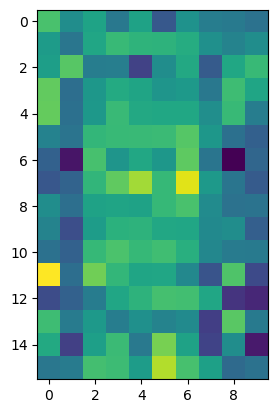

In [59]:
plt.imshow(output.cpu())

In [ ]:
# Deal with data loading
dataPath = "/Users/landauland/Documents/ML-Datasets/cifar-10-batches-py"
import sys, os
sys.path.append(dataPath) 

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Get data
numBatches = 5 # hard coded
getName = lambda batch : f"data_batch_{batch}"
data = []
labels = []
for cBatch in range(1,numBatches+1):
    cDataDict = unpickle(os.path.join(dataPath,getName(cBatch)))
    data.append(cDataDict[b'data'])
    labels.append(cDataDict[b'labels'])
data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)

testDict = unpickle(os.path.join(dataPath,'test_batch'))
dataTest = testDict[b'data']
labelTest = testDict[b'labels']

numClasses = 10 # its cifar-10
numImTr, imDim = data.shape
numImTe = dataTest.shape[0]
print(f"{numImTr}, {numImTe}, {imDim}")

#trainloader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(dataTest, batch_size=16, shuffle=True, num_workers=2)